## Midterm experiment redo

In [5]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm
import pandas as pd
import json
from datetime import datetime


In [6]:
def stock_price_simulator(S0, mu, sigma, T, N, M):
    """_summary_

    Args:
        S0 (_type_): initial stock price
        mu (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        N (_type_): number of time steps
        M (_type_): number of simulations

    Returns:
        S : Stock price Paths of M simulations
    """
    dt = T/N
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(loc=0.0, scale=1.0, size=M))
    
    return S

def payoff_fun(S, K, option_type):
    """

    Args:
        S (_type_): Stock price
        K (_type_): Strike price
        option_type (_type_): type of option, call or put
    Returns:
        payoff : payoff of the option
    """
    if option_type == 'call':
        return np.maximum(S - K, 0)
    elif option_type == 'put':
        return np.maximum(K - S, 0)
    
    
def black_scholes(S, K, r, sigma, T, option_type='call'):
    """ 
    Calculate the price of a European option using Black-Scholes formula

    Args:
        S (_type_): Initial Stock price
        K (_type_): Strike price
        r (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        option_type (str, optional): type of option .

    Returns:
        price of the option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2), norm.cdf(d1)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1), -norm.cdf(-d1)
    

def bermudan_option_binomial(S0, K, T, r, sigma, N, exercise_dates, option_type="put"):
    """
    Price a Bermudan option and calculate delta using the Binomial Tree method.
    
    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - sigma: Volatility of the underlying asset
    - N: Number of steps in the binomial tree
    - exercise_dates: List of times (as fractions of T) at which early exercise is allowed
    - option_type: "call" for call option, "put" for put option
    
    Returns:
    - Tuple of (option_price, delta)
    """
    
    # Calculate parameters for binomial tree
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    
    # Initialize asset prices at maturity
    stock_prices = np.zeros(N + 1)
    stock_prices[0] = S0 * d**N
    for i in range(1, N + 1):
        stock_prices[i] = stock_prices[i - 1] * u / d

    # Initialize option values at maturity
    option_values = np.maximum(0, (stock_prices - K) if option_type == "call" else (K - stock_prices))
    
    # Backward induction
    for i in range(N - 1, -1, -1):
        # Step back in time for stock prices
        stock_prices = stock_prices[:-1] * u
        
        # Calculate continuation values
        option_values = np.exp(-r * dt) * (p * option_values[1:] + (1 - p) * option_values[:-1])
        
        # Apply early exercise at specified dates
        if i * dt in exercise_dates:
            exercise_values = np.maximum(0, (stock_prices - K) if option_type == "call" else (K - stock_prices))
            option_values = np.maximum(option_values, exercise_values)
        
        # Calculate delta at the first step
        if i == 1:
            # Store option values for delta calculation
            option_up = option_values[1]
            option_down = option_values[0]
            stock_up = S0 * u
            stock_down = S0 * d
            
    # Calculate delta using finite difference
    delta = (option_up - option_down) / (stock_up - stock_down)
    
    return option_values[0], delta


def calculate_hedge_error(S0, K, mu, sigma, T, hedge_freq, monitoring_dates, hedging_dates, M = 10000):
    hedge_error = np.zeros(M)
    for m in tqdm(range(M)):
        V0, delta = bermudan_option_binomial(S0, K, T, mu, sigma, 200, monitoring_dates, option_type="put")
        #print(f'Price of the option: {V0}', f'Delta: {delta}')
        cash_flow = V0 - delta * S0
        No_of_shares = delta
        updated_monitoring_dates = monitoring_dates
        #print(f'Initial cash flow: {cash_flow}', f'Number of shares to buy: {No_of_shares}')
        S = stock_price_simulator(S0, mu, sigma, T, hedge_freq, 1).flatten()
        #print(S)
        dt = T/hedge_freq
        #print("time stpes in hedging dates", dt)
        for i in range(1, len(hedging_dates)- 1):
            #print(f'Hedging date: {i*dt}')
            updated_monitoring_dates = updated_monitoring_dates - dt
            updated_monitoring_dates = updated_monitoring_dates[updated_monitoring_dates > 0]    
            #print(f'Updated monitoring dates: {updated_monitoring_dates}')
            V1, delta2 = bermudan_option_binomial(S[i], K, updated_monitoring_dates[-1], mu, sigma, 100, updated_monitoring_dates, option_type="put")
            #V1, delta2 = binomial_option_pricing(S[i], K, updated_monitoring_dates[-1], mu, sigma, 100, updated_monitoring_dates, option_type='put')
            if i*dt in monitoring_dates:
                #print("inside", i*dt)
                #print(f'Price of stock: {S[i]}', f'Price of the option: {V1}', f'K: {K}', f'payoff : {payoff_fun(S[i], K, "put")}')
                if payoff_fun(S[i], K, 'put') > V1:
                    #print("Exercise")
                    break
                cash_flow = cash_flow * np.exp(mu*dt) - (delta2 - No_of_shares) * S[i]
                No_of_shares = delta2
                #print(f'Cash flow: {cash_flow}', f'Number of shares to buy: {No_of_shares}')
            else:
                cash_flow = cash_flow * np.exp(mu*dt) - (delta2 - No_of_shares) * S[i]
                No_of_shares = delta2
                #print("Not in monitoring date")
            #print("i", i, No_of_shares)
        if i == len(hedging_dates)-2:
            #print("Last date", i)
            payoff_last = payoff_fun(S[i+1], K, 'put')   
            final_cash_flow = cash_flow * np.exp(mu*dt) + No_of_shares * S[i+1]
        else:
            #print("i at end", i*dt, V1, payoff_fun(S[i], K, 'put'))
            payoff_last = payoff_fun(S[i], K, 'put')
            final_cash_flow = cash_flow * np.exp(mu*dt) + No_of_shares * S[i]
        #print(f'Final Hedge Error: {payoff_last - final_cash_flow}')
        hedge_error[m] = payoff_last - final_cash_flow
        
    return hedge_error

    
def create_shallow_NN(input_dim, hidden_units):
    """
    Create a shallow neural network with 1 hidden layer

    Args:
        input_dim (int): number of nodes in input layer
        hidden_units (int): number of nodes in hidden layer

    Returns:
        model : Neural network model
    """
    model = Sequential()
    # Use Input layer for specifying input shape
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(hidden_units, activation='relu', kernel_initializer='random_uniform', bias_initializer= 'random_uniform'))
    model.add(Dense(1, activation='linear', kernel_initializer='random_uniform', bias_initializer= 'random_uniform'))
    
    return model

    
def expected_value(wi, bi, Stm_1, r, sigma, dt):
    """
    Calculate E[max(wi * Stm + bi, 0) | St] based on the cases provided.

    Parameters:
    - wi : float, weight parameter
    - bi : float, bias parameter
    - Stm : float, price at time t_m

    Returns:
    - float, expected value based on the case
    """
    if wi >= 0 and bi >= 0:
        # Case 1: Price of a forward contract
        ### Forward Price Impelmentation
        return wi * Stm_1 * np.exp(r * dt) + bi

    elif wi > 0 and bi < 0:
        # Case 2: Value of a European call option
        strike = -bi / wi
        # Using max(0, Stm - strike) to approximate the expectation
        ### Implement
        return wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='call')

    elif wi < 0 and bi > 0:
        # Case 3: Value of a European put option
        strike = -bi / wi
        return - wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='put')

    elif wi <= 0 and bi <= 0:
        # Case 4: Expected value is 0
        return 0.0
    
def cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_prices, r, sigma, dt, M, normalizer):
    """ Calculate the continuation value of the Bermudan option

    Args:
        w1 (array): Weights of the first layer
        b1 (array): Biases of the first layer
        w2 (array): Weights of the second layer
        b2 (float): Biases of the second layer
        no_hidden_units (int): Number of hidden units
        stock_prices (float): Stock prices at time
        r (float): Risk free rate
        sigma (float): volatility
        dt (_type_): time step
        M (_type_): number of simulations(samples)
        normalizer (_type_): normalizer for the stock prices

    Returns:
        _type_: _description_
    """
    normalized_stock_values = stock_prices/normalizer
    continuation_value = np.zeros(M)
    for j in range(M):
        for i in range(no_hidden_units):
            continuation_value[j] += expected_value(w1[i], b1[i], normalized_stock_values[j], r, sigma, dt) * w2[i]
        continuation_value[j] += b2
    
    return continuation_value * np.exp(-r*dt)





def stock_price_simulator(S0, mu, sigma, T, N, M):
    """_summary_

    Args:
        S0 (_type_): initial stock price
        mu (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        N (_type_): number of time steps
        M (_type_): number of simulations

    Returns:
        S : Stock price Paths of M simulations
    """
    dt = T/N
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(size=M))
    
    return S

def payoff_fun(S, K, option_type):
    """

    Args:
        S (_type_): Stock price
        K (_type_): Strike price
        option_type (_type_): type of option, call or put
    Returns:
        payoff : payoff of the option
    """
    if option_type == 'call':
        return np.maximum(S - K, 0)
    elif option_type == 'put':
        return np.maximum(K - S, 0)
    
def create_shallow_NN(input_dim, hidden_units):
    """
    Create a shallow neural network with 1 hidden layer

    Args:
        input_dim (int): number of nodes in input layer
        hidden_units (int): number of nodes in hidden layer

    Returns:
        model : Neural network model
    """
    model = Sequential()
    # Use Input layer for specifying input shape
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(hidden_units, activation='relu', kernel_initializer='random_uniform', bias_initializer= 'random_uniform'))
    model.add(Dense(1, activation='linear', kernel_initializer='random_normal', bias_initializer= 'random_uniform'))
    
    return model

def black_scholes(S, K, r, sigma, T, option_type='call'):
    """ 
    Calculate the price of a European option using Black-Scholes formula

    Args:
        S (_type_): Initial Stock price
        K (_type_): Strike price
        r (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        option_type (str, optional): type of option .

    Returns:
        price of the option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
def expected_value(wi, bi, Stm_1, r, sigma, dt):
    """
    Calculate E[max(wi * Stm + bi, 0) | St] based on the cases provided.

    Parameters:
    - wi : float, weight parameter
    - bi : float, bias parameter
    - Stm : float, price at time t_m

    Returns:
    - float, expected value based on the case
    """
    if wi >= 0 and bi >= 0:
        # Case 1: Price of a forward contract
        ### Forward Price Impelmentation
        return wi * Stm_1 * np.exp(r * dt) + bi

    elif wi > 0 and bi < 0:
        # Case 2: Value of a European call option
        strike = -bi / wi
        # Using max(0, Stm - strike) to approximate the expectation
        ### Implement
        return wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='call')

    elif wi < 0 and bi > 0:
        # Case 3: Value of a European put option
        strike = -bi / wi
        return - wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='put')

    elif wi <= 0 and bi <= 0:
        # Case 4: Expected value is 0
        return 0.0
    
def cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_prices, r, sigma, dt, M, normalizer):
    """ Calculate the continuation value of the Bermudan option

    Args:
        w1 (array): Weights of the first layer
        b1 (array): Biases of the first layer
        w2 (array): Weights of the second layer
        b2 (float): Biases of the second layer
        no_hidden_units (int): Number of hidden units
        stock_prices (float): Stock prices at time
        r (float): Risk free rate
        sigma (float): volatility
        dt (_type_): time step
        M (_type_): number of simulations(samples)
        normalizer (_type_): normalizer for the stock prices

    Returns:
        _type_: _description_
    """
    normalized_stock_values = stock_prices/normalizer
    continuation_value = np.zeros(M)
    for j in range(M):
        for i in range(no_hidden_units):
            continuation_value[j] += expected_value(w1[i], b1[i], normalized_stock_values[j], r, sigma, dt) * w2[i]
        continuation_value[j] += b2
    
    return continuation_value * np.exp(-r*dt)




def RLNN_Algo(S0, K, r, vol, sample_size, no_mon, T, style, no_hidden_units, l_rate2):
    """
    Args:
        S0 (): Initial stock price
        K (_type_): Stirke price
        r (_type_): risk free rate
        vol (_type_): volatility
        sample_size (_type_): number of samples to generate
        no_mon (_type_): Number of monitoring dates
        style (_type_): option type
        no_hidden_units (_type_): number of hidden units in the neural network
    """
    
    weights = []
    errors = []
    N = no_mon
    
    stock_paths = stock_price_simulator(S0, r, vol, T, no_mon, sample_size)
    ## Initialize the option price matrix
    option_price = np.zeros(stock_paths.shape)
    ## Calculate the option price at the maturity date
    option_price[:, N] = payoff_fun(stock_paths[:, N], K, style)
    payoff_T = payoff_fun(stock_paths[:, N], K, style)
     
    X = stock_paths[:, N].reshape(-1, 1)
    ## Normalize the stock prices
    normalizer = S0
    normalized_stock_paths = stock_paths[:, N]/normalizer
    ## X_train and y_train for the neural network
    X = normalized_stock_paths.reshape(-1, 1)
    y = payoff_T.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    # Compile the model
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
    model2  = create_shallow_NN(1, no_hidden_units)
    model2.compile(loss='mean_squared_error', optimizer=Adam(l_rate2))
    ## Train the model  
    model2.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
              validation_data=(X_test, y_test), callbacks=[es], verbose = 0)
    
    # Test the model
    y_hat_val = model2.predict(X_test)
    
    errors.append(np.mean((y_test - y_hat_val)**2)) ## Store the errors for Last monitoring date
    
    ## Get the weights of the model
    w1 = model2.layers[0].get_weights()[0].reshape(-1)
    b1 = model2.layers[0].get_weights()[1].reshape(-1)
    w2 = model2.layers[1].get_weights()[0].reshape(-1)
    b2 = model2.layers[1].get_weights()[1].reshape(-1)
    
    ## Store the weights 
    weights.append(model2.get_weights())
    
    ## Calculate the continuation value 
    continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, N-1], r, vol, T/N, sample_size, normalizer)
    ##print(continuation_value[continuation_value < 0])
    fun_h = payoff_fun(stock_paths[:, N-1], K, style)               # Payoff at the previous monitoring date
    if N == 1:
        option_price[:, N-1] = continuation_value
    else:
        option_price[:, N-1] = np.maximum(fun_h, continuation_value)    # Option price at the previous monitoring date
    
    
    ## Calculate the option price at the previous monitoring dates
    
    model2.optimizer.learning_rate.assign(0.01)
    
    for i in range(N-1, 0, -1):
        normalizer = S0
        normalized_stock_paths = stock_paths[:, i]/normalizer
        X = normalized_stock_paths.reshape(-1, 1)
        y = option_price[:, i].reshape(-1, 1)
        es2 = EarlyStopping(monitor='val_loss', mode='min', patience=20,restore_best_weights=True, min_delta=0.00001, verbose=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model2.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
                  validation_data=(X_test, y_test), callbacks=[es2], verbose =0)
        
        y_hat = model2.predict(X_test)
        
        errors.append(np.mean((y_test - y_hat)**2))    ## Store the errors for the previous monitoring dates
        
        # compute the continuation value
        w1 = model2.layers[0].get_weights()[0].reshape(-1)
        b1 = model2.layers[0].get_weights()[1].reshape(-1)
        w2 = model2.layers[1].get_weights()[0].reshape(-1)
        b2 = model2.layers[1].get_weights()[1].reshape(-1)
        weights.append(model2.get_weights())
        continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, i-1], r, vol, T/N, sample_size, normalizer)
        fun_h = payoff_fun(stock_paths[:, i-1], K, style)            # Payoff at the previous monitoring date
        if i == 1:
            option_price[:, i-1] = continuation_value
        
        else:
            option_price[:, i-1] = np.maximum(fun_h, continuation_value)    
        
    return option_price[0,0] , weights, errors



def portfolio_value(weights, stock_price, r, sigma, dt, S0):
    
    weights_layer1 = weights[0].flatten()
    weights_layer2 = weights[2].flatten()
    bias_layer1 = weights[1]
    bias_layer2 = weights[3][0]
    St = stock_price/S0
    
    cost = bias_layer2
    for i in range(len(weights_layer1)):
        wi, bi = weights_layer1[i], bias_layer1[i]
        
        if wi >= 0 and bi >= 0:
            # Forward Price
            temp_cost = wi * St * np.exp(r * dt) + bi
        elif wi > 0 and bi < 0:
            # European Call Option
            strike = -bi / wi
            temp_cost = wi * black_scholes(St, strike, r, sigma, dt, option_type='call')
        elif wi < 0 and bi > 0:
            # European Put Option
            strike = -bi / wi
            temp_cost = -wi * black_scholes(St, strike, r, sigma, dt, option_type='put')
        else:
            # Expected value is 0
            temp_cost = 0.0
            
        cost += temp_cost * weights_layer2[i]
    
    return cost * np.exp(-r * dt)

def check_payoffs(stock_price, weights, S0):
    """
    Given a single stock_price, compute the total 
    payoff implied by the 2-layer NN with piecewise logic.
    
    :param stock_price:  current price of the underlying (float)
    :param weights:      a tuple/list containing 
                         [weights_layer1, bias_layer1, weights_layer2, bias_layer2]
    :param S0:           normalizing constant (e.g. initial stock price)
    :return:             total payoff (float)
    """
    payoffs = 0.0    
    # Extract layers
    weights_layer1 = weights[0].flatten()  # array of w1_i
    bias_layer1    = weights[1]  # array of b1_i
    weights_layer2 = weights[2].flatten()  # array of w2_i
    bias_layer2    = weights[3][0]  # float or array of length 1

    # Normalize
    normalized_stock = stock_price / S0
    
    # Start from second-layer bias
    # (if bias_layer2 is an array, do bias_layer2[0])
    payoffs = bias_layer2

    # Loop over all first-layer neurons
    for i in range(len(weights_layer1)):
        w1i = weights_layer1[i]
        b1i = bias_layer1[i]
        w2i = weights_layer2[i]

        # Case 1: w1 >= 0, b1 >= 0 => Forward contract
        if w1i >= 0 and b1i >= 0:
            payoffs += w2i * (w1i * normalized_stock + b1i)

        # Case 2: w1 > 0, b1 < 0 => call-like payoff
        elif w1i > 0 and b1i < 0:
            strike_call = -b1i / w1i
            call_payoff = max(normalized_stock - strike_call, 0)
            payoffs += w2i * w1i * call_payoff

        # Case 3: w1 < 0, b1 > 0 => put-like payoff
        elif w1i < 0 and b1i > 0:
            strike_put = -b1i / w1i
            put_payoff = max(strike_put - normalized_stock, 0)
            payoffs -= w2i * w1i * put_payoff

        else:
            # The "else" might be w1 <= 0, b1 <= 0 => payoff is effectively 0
            0.0

    return payoffs

def cal_continuation_value2(weights, no_hidden_units, stock_prices, r, sigma, dt, normalizer):
    """ Calculate the continuation value of the Bermudan option

    Args:
        w1 (array): Weights of the first layer
        b1 (array): Biases of the first layer
        w2 (array): Weights of the second layer
        b2 (float): Biases of the second layer
        no_hidden_units (int): Number of hidden units
        stock_prices (float): Stock prices at time
        r (float): Risk free rate
        sigma (float): volatility
        dt (_type_): time step
        M (_type_): number of simulations(samples)
        normalizer (_type_): normalizer for the stock prices

    Returns:
        _type_: _description_
    """
     ## Get the weights of the model
    w1 = weights[0].reshape(-1)
    b1 = weights[1].reshape(-1)
    w2 = weights[2].reshape(-1)
    b2 = weights[3].reshape(-1)
    normalized_stock_values = stock_prices/normalizer
    continuation_value = 0
    for i in range(no_hidden_units):
        continuation_value += expected_value(w1[i], b1[i], normalized_stock_values, r, sigma, dt) * w2[i]
        #print(continuation_value)
    continuation_value += b2
    
    return continuation_value * np.exp(-r*dt)

def semi_static_hedging_simulation(stock_paths, weights, r, sigma, T, M, S0, K, price, hidden_nodes):
    N = len(stock_paths)
    dt = T / M
    hedging_errors = np.zeros(N, dtype=float)

    for i in range(N):
        cash_account = price
        weights_now = weights[-1]
        
        # Initial portfolio setup
        cash_account -= portfolio_value(weights_now, stock_paths[i][0], r, sigma, dt, S0)
        
        #print("cash account at the start", cash_account)
        
        for j in range(1, M):
            cash_account *= np.exp(r * dt)
            
            Exercise_value = payoff_fun(stock_paths[i][j], K, "put")
            weights_next = weights[-(j+1)]
            cont_value = cal_continuation_value2(weights_next, hidden_nodes, stock_paths[i][j], r, sigma, dt, S0)
            
            if Exercise_value > cont_value:
                # At exercise: get payoff from current portfolio and exercise
                portfolio_t = check_payoffs(stock_paths[i][j], weights_now, S0)
                cash_account += portfolio_t
                hedging_errors[i] = cash_account - Exercise_value
                break
            
            # Rebalancing: get payoff from old portfolio, pay for new one
            portfolio_t = check_payoffs(stock_paths[i][j], weights_now, S0)
            cash_account += portfolio_t
            
            weights_now = weights[-(j+1)]
            cash_account -= portfolio_value(weights_now, stock_paths[i][j], r, sigma, dt, S0)
        else:
            cash_account *= np.exp(r * dt)
            portfolio_t = check_payoffs(stock_paths[i][M], weights_now, S0)
            cash_account += portfolio_t
            payoff_T = payoff_fun(stock_paths[i][M], K, "put")
            hedging_errors[i] = cash_account - payoff_T
            
    return hedging_errors

# stock_prices = stock_price_simulator(S0, r, sigma, T, M, 10000)
# hedge_error1 = hedging_simulation_proper_pnl(stock_prices, weights3, r, sigma, T, M, S0, 50, price3, nodes)

# stock_prices = stock_price_simulator(S0, r, sigma, T, M, 10000)
# hedge_error08 = hedging_simulation_proper_pnl(stock_prices, weights2, r, sigma, T, M, S0, 50 * 0.8, price2, nodes)

# stock_prices = stock_price_simulator(S0, r, sigma, T, M, 10000)
# hedge_error12 = hedging_simulation_proper_pnl(stock_prices, weights, r, sigma, T, M, S0, 50 * 1.2, price, nodes)

# plt.hist(hedge_error12,bins=50, edgecolor='black',color='r', alpha=0.7, label='K/S0=1.2')
# plt.hist(hedge_error08, bins=50, edgecolor='k',color='g',  alpha=0.7, label='K/S0 = 0.8')
# plt.hist(hedge_error1, bins=50, edgecolor='k', alpha=0.7, label='K/S0 = 1')
# plt.legend()
# plt.show()

Running experiment for volatility = 0.1
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


C:\Users\nitai\AppData\Local\Temp\ipykernel_55456\1792776672.py:392: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
Epoch 536: early stopping
Restoring model weights from the end of the best epoch: 516.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 10.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 46.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
Epoch 108: early stopping
Restoring model weights from the end of the best epoch: 88.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step
Epoch 263: early stopping
Restoring 

100%|██████████| 10000/10000 [06:46<00:00, 24.57it/s]


RLNN mean hedge error (K=0.8): 0.008959611139088833
Binomial mean hedge error (K=0.8): -1.7259923447187006e-05
RLNN mean hedge error (K=1.0): -0.0005432608575613728
Binomial mean hedge error (K=1.0): -0.014500698522864473
RLNN mean hedge error (K=1.2): -0.0019377038871442756
Binomial mean hedge error (K=1.2): 0.005062593248268493


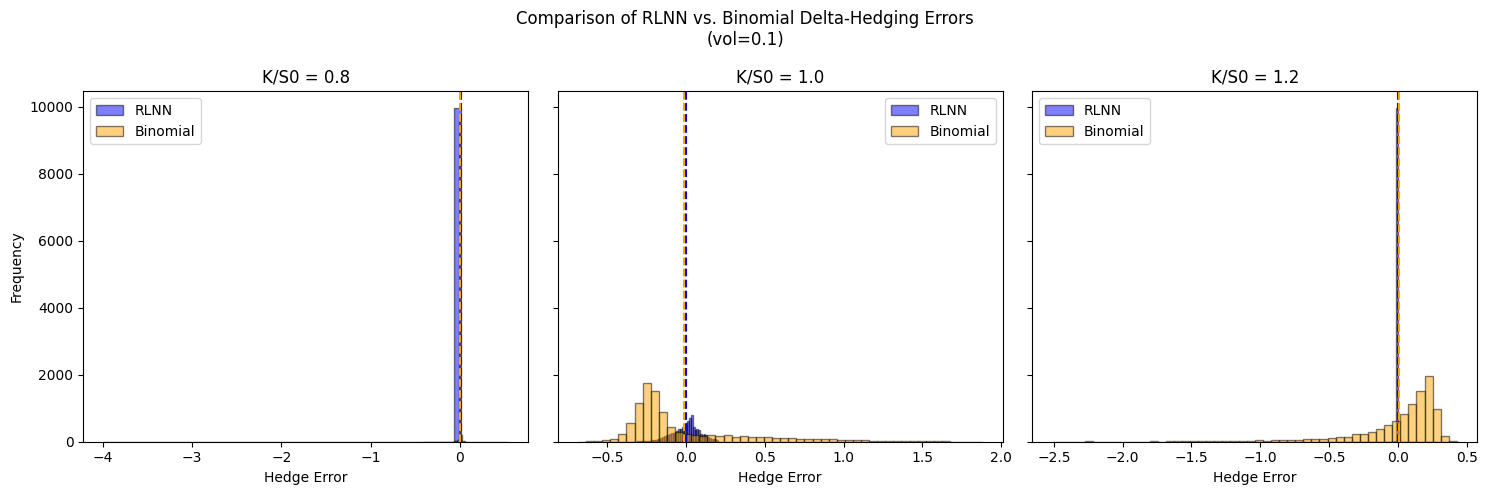

Running experiment for volatility = 0.2
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
Epoch 398: early stopping
Restoring model weights from the end of the best epoch: 378.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
Epoch 238: early stopping
Restoring model weights from the end of the best epoch: 218.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
Epoch 112: early stopping
Restoring model weights from the end of the best epoch: 92.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
Epoch 781: early stopping
Restoring model weights from the end of the best epoch: 761.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 9.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
Epoch 195: early stopping
Restoring model weights from the end of the best epoch: 175.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
Epoch 823: early stopping
Restoring model weights from the end of the bes

100%|██████████| 10000/10000 [16:02<00:00, 10.39it/s]


RLNN mean hedge error (K=0.8): -0.0006513361700977438
Binomial mean hedge error (K=0.8): -0.001069250448448711
RLNN mean hedge error (K=1.0): -0.0017822660395864726
Binomial mean hedge error (K=1.0): -0.013989183933796097
RLNN mean hedge error (K=1.2): -0.003020854629593177
Binomial mean hedge error (K=1.2): -0.04087831930967692


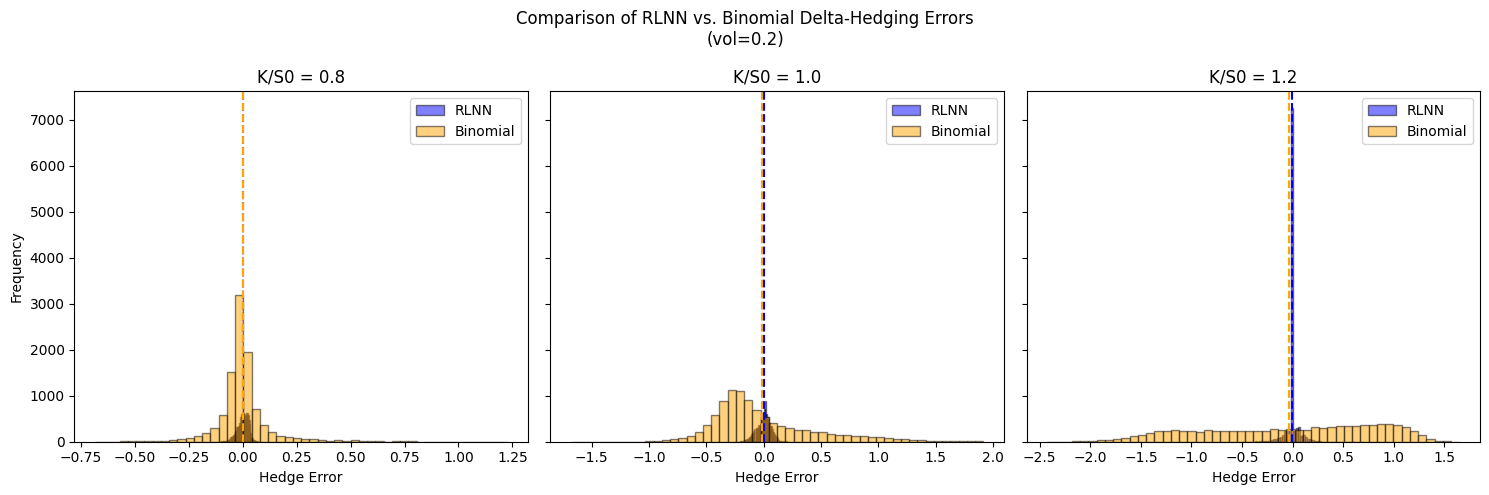

Running experiment for volatility = 0.3
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
Epoch 609: early stopping
Restoring model weights from the end of the best epoch: 589.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
Epoch 323: early stopping
Restoring model weights from the end of the best epoch: 303.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 121: early stopping
Restoring model weights from the end of the best epoch: 101.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 909: early stopping
Restoring model weights from the end of the best epoch: 889.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 28.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
Epoch 367: early stopping
Restoring model weights from the end of the best epoch: 347.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
Epoch 494: early stopping
Restoring model weights from the end of the best 

100%|██████████| 10000/10000 [12:48<00:00, 13.02it/s]


RLNN mean hedge error (K=0.8): 6.142841986238097e-05
Binomial mean hedge error (K=0.8): -0.0037203665696814796
RLNN mean hedge error (K=1.0): -0.003722910104966522
Binomial mean hedge error (K=1.0): -0.01902943490137982
RLNN mean hedge error (K=1.2): 0.005111104125314413
Binomial mean hedge error (K=1.2): -0.05537322017420837


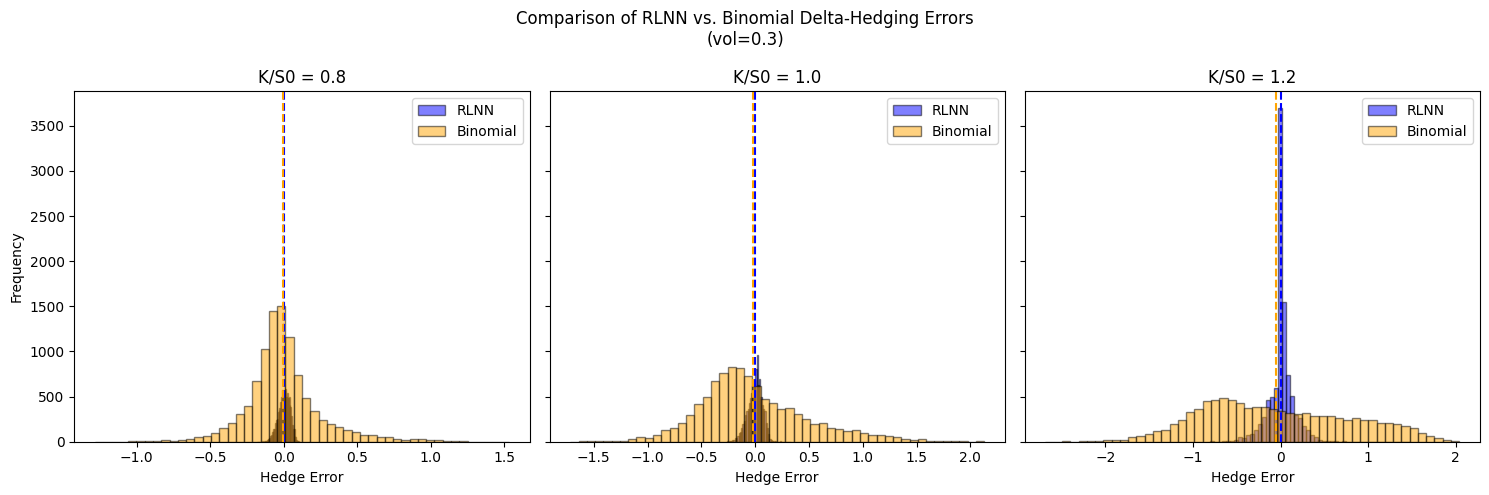

Saved hedge_error_rlnn_08_vol_0.1_10000 to hedge_error_rlnn_08_vol_0.1_10000_20250104_213123.json
Saved hedge_error_bin_08_vol_0.1_10000 to hedge_error_bin_08_vol_0.1_10000_20250104_213123.json
Saved hedge_error_rlnn_10_vol_0.1_10000 to hedge_error_rlnn_10_vol_0.1_10000_20250104_213123.json
Saved hedge_error_bin_10_vol_0.1_10000 to hedge_error_bin_10_vol_0.1_10000_20250104_213123.json
Saved hedge_error_rlnn_12_vol_0.1_10000 to hedge_error_rlnn_12_vol_0.1_10000_20250104_213123.json
Saved hedge_error_bin_12_vol_0.1_10000 to hedge_error_bin_12_vol_0.1_10000_20250104_213123.json
Saved hedge_error_rlnn_08_vol_0.2_10000 to hedge_error_rlnn_08_vol_0.2_10000_20250104_213123.json
Saved hedge_error_bin_08_vol_0.2_10000 to hedge_error_bin_08_vol_0.2_10000_20250104_213123.json
Saved hedge_error_rlnn_10_vol_0.2_10000 to hedge_error_rlnn_10_vol_0.2_10000_20250104_213123.json
Saved hedge_error_bin_10_vol_0.2_10000 to hedge_error_bin_10_vol_0.2_10000_20250104_213123.json
Saved hedge_error_rlnn_12_vol_

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime

# =========================================================================
# Utility function to save hedge errors with timestamps
# =========================================================================

def save_hedge_errors_with_timestamp(errors_dict):
    """
    Saves each entry in `errors_dict` as a separate JSON file, appending a timestamp.
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # Generate timestamp
    for name, errors in errors_dict.items():
        filename = f"{name}_{timestamp}.json"  # Create unique filename with timestamp
        with open(filename, 'w') as f:
            json.dump(errors, f, indent=4)
        print(f"Saved {name} to {filename}")

# =========================================================================
# Main experiment parameters (independent of volatility)
# =========================================================================

S0 = 50
r = 0.06
T = 1.0
M = 4            # number of monitoring dates for RLNN
N_RLNN = 10000    # number of paths for RLNN training
nodes = 16       # hidden layer size
style = 'put'    # put option
l_rate = 0.05

# Moneyness ratios
K_08 = 0.8 * S0
K_10 = 1.0 * S0
K_12 = 1.2 * S0

# Hedging parameters
hedge_freq = 252
hedging_dates = np.linspace(0, T, hedge_freq + 1)
monitoring_dates = np.array([0.25, 0.5, 0.75, 1])

# Number of out-of-sample paths
n_test = 10000

# For Binomial-based delta-hedging
steps_binom = 100

# =========================================================================
# Run the experiment for multiple volatilities
# =========================================================================

volatility_list = [0.1, 0.2, 0.3]
all_hedge_errors = {}  # We'll collect all hedge errors in a single dict to save

for vol in volatility_list:
    print("="*60)
    print(f"Running experiment for volatility = {vol}")
    print("="*60)

    # A) RLNN Price & Weights for each moneyness ratio
    price_08, weights_08, errors_08 = RLNN_Algo(
        S0, K_08, r, vol, N_RLNN, M, T, style, nodes, l_rate
    )
    price_10, weights_10, errors_10 = RLNN_Algo(
        S0, K_10, r, vol, N_RLNN, M, T, style, nodes, l_rate
    )
    price_12, weights_12, errors_12 = RLNN_Algo(
        S0, K_12, r, vol, N_RLNN, M, T, style, nodes, l_rate
    )

    print("RLNN Price (K=0.8*S0):", price_08)
    print("RLNN Price (K=1.0*S0):", price_10)
    print("RLNN Price (K=1.2*S0):", price_12)

    # B) Generate out-of-sample paths for hedging
    test_paths_08 = stock_price_simulator(S0, r, vol, T, M, n_test)
    test_paths_10 = stock_price_simulator(S0, r, vol, T, M, n_test)
    test_paths_12 = stock_price_simulator(S0, r, vol, T, M, n_test)

    # C) RLNN Hedging Errors
    hedge_error_rlnn_08 = semi_static_hedging_simulation(
        test_paths_08, weights_08, r, vol, T, M, S0, K_08, price_08, nodes
    )
    hedge_error_rlnn_10 = semi_static_hedging_simulation(
        test_paths_10, weights_10, r, vol, T, M, S0, K_10, price_10, nodes
    )
    hedge_error_rlnn_12 = semi_static_hedging_simulation(
        test_paths_12, weights_12, r, vol, T, M, S0, K_12, price_12, nodes
    )

    # D) Binomial Delta Hedging Errors
    hedge_error_bin_08 = calculate_hedge_error(
        S0, K_08, r, vol, T, hedge_freq, monitoring_dates, hedging_dates,
        M=10000)
    hedge_error_bin_10 = calculate_hedge_error(
        S0, K_10, r, vol, T, hedge_freq, monitoring_dates, hedging_dates,
        M=10000)
    hedge_error_bin_12 = calculate_hedge_error(
        S0, K_12, r, vol, T, hedge_freq, monitoring_dates, hedging_dates,
        M=10000)

    # E) Print summary statistics
    print("RLNN mean hedge error (K=0.8):", np.mean(hedge_error_rlnn_08))
    print("Binomial mean hedge error (K=0.8):", np.mean(hedge_error_bin_08))
    print("RLNN mean hedge error (K=1.0):", np.mean(hedge_error_rlnn_10))
    print("Binomial mean hedge error (K=1.0):", np.mean(hedge_error_bin_10))
    print("RLNN mean hedge error (K=1.2):", np.mean(hedge_error_rlnn_12))
    print("Binomial mean hedge error (K=1.2):", np.mean(hedge_error_bin_12))

    # F) Plot histograms comparing RLNN vs. Binomial for each strike ratio
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    # -- K=0.8*S0
    axes[0].hist(hedge_error_rlnn_08, bins=50, alpha=0.5, color='blue',
                 edgecolor='black', label='RLNN')
    axes[0].hist(hedge_error_bin_08, bins=50, alpha=0.5, color='orange',
                 edgecolor='black', label='Binomial')
    axes[0].axvline(x=hedge_error_rlnn_08.mean(), color='blue', linestyle='--')
    axes[0].axvline(x=hedge_error_bin_08.mean(), color='orange', linestyle='--')
    axes[0].set_title("K/S0 = 0.8")
    axes[0].legend()
    axes[0].set_xlabel("Hedge Error")
    axes[0].set_ylabel("Frequency")

    # -- K=1.0*S0
    axes[1].hist(hedge_error_rlnn_10, bins=50, alpha=0.5, color='blue',
                 edgecolor='black', label='RLNN')
    axes[1].hist(hedge_error_bin_10, bins=50, alpha=0.5, color='orange',
                 edgecolor='black', label='Binomial')
    axes[1].axvline(x=hedge_error_rlnn_10.mean(), color='blue', linestyle='--')
    axes[1].axvline(x=hedge_error_bin_10.mean(), color='orange', linestyle='--')
    axes[1].set_title("K/S0 = 1.0")
    axes[1].legend()
    axes[1].set_xlabel("Hedge Error")

    # -- K=1.2*S0
    axes[2].hist(hedge_error_rlnn_12, bins=50, alpha=0.5, color='blue',
                 edgecolor='black', label='RLNN')
    axes[2].hist(hedge_error_bin_12, bins=50, alpha=0.5, color='orange',
                 edgecolor='black', label='Binomial')
    axes[2].axvline(x=hedge_error_rlnn_12.mean(), color='blue', linestyle='--')
    axes[2].axvline(x=hedge_error_bin_12.mean(), color='orange', linestyle='--')
    axes[2].set_title("K/S0 = 1.2")
    axes[2].legend()
    axes[2].set_xlabel("Hedge Error")

    plt.suptitle(f"Comparison of RLNN vs. Binomial Delta-Hedging Errors\n(vol={vol})")
    plt.tight_layout()
    plt.show()

    # G) Add the results to the dictionary for saving
    # We'll convert each NumPy array to a Python list via .tolist()
    all_hedge_errors[f"hedge_error_rlnn_08_vol_{vol}_10000"] = hedge_error_rlnn_08.tolist()
    all_hedge_errors[f"hedge_error_bin_08_vol_{vol}_10000"] = hedge_error_bin_08.tolist()
    all_hedge_errors[f"hedge_error_rlnn_10_vol_{vol}_10000"] = hedge_error_rlnn_10.tolist()
    all_hedge_errors[f"hedge_error_bin_10_vol_{vol}_10000"] = hedge_error_bin_10.tolist()
    all_hedge_errors[f"hedge_error_rlnn_12_vol_{vol}_10000"] = hedge_error_rlnn_12.tolist()
    all_hedge_errors[f"hedge_error_bin_12_vol_{vol}_10000"] = hedge_error_bin_12.tolist()

# =========================================================================
# Finally, save all hedge errors to separate JSON files with timestamp
# =========================================================================

save_hedge_errors_with_timestamp(all_hedge_errors)


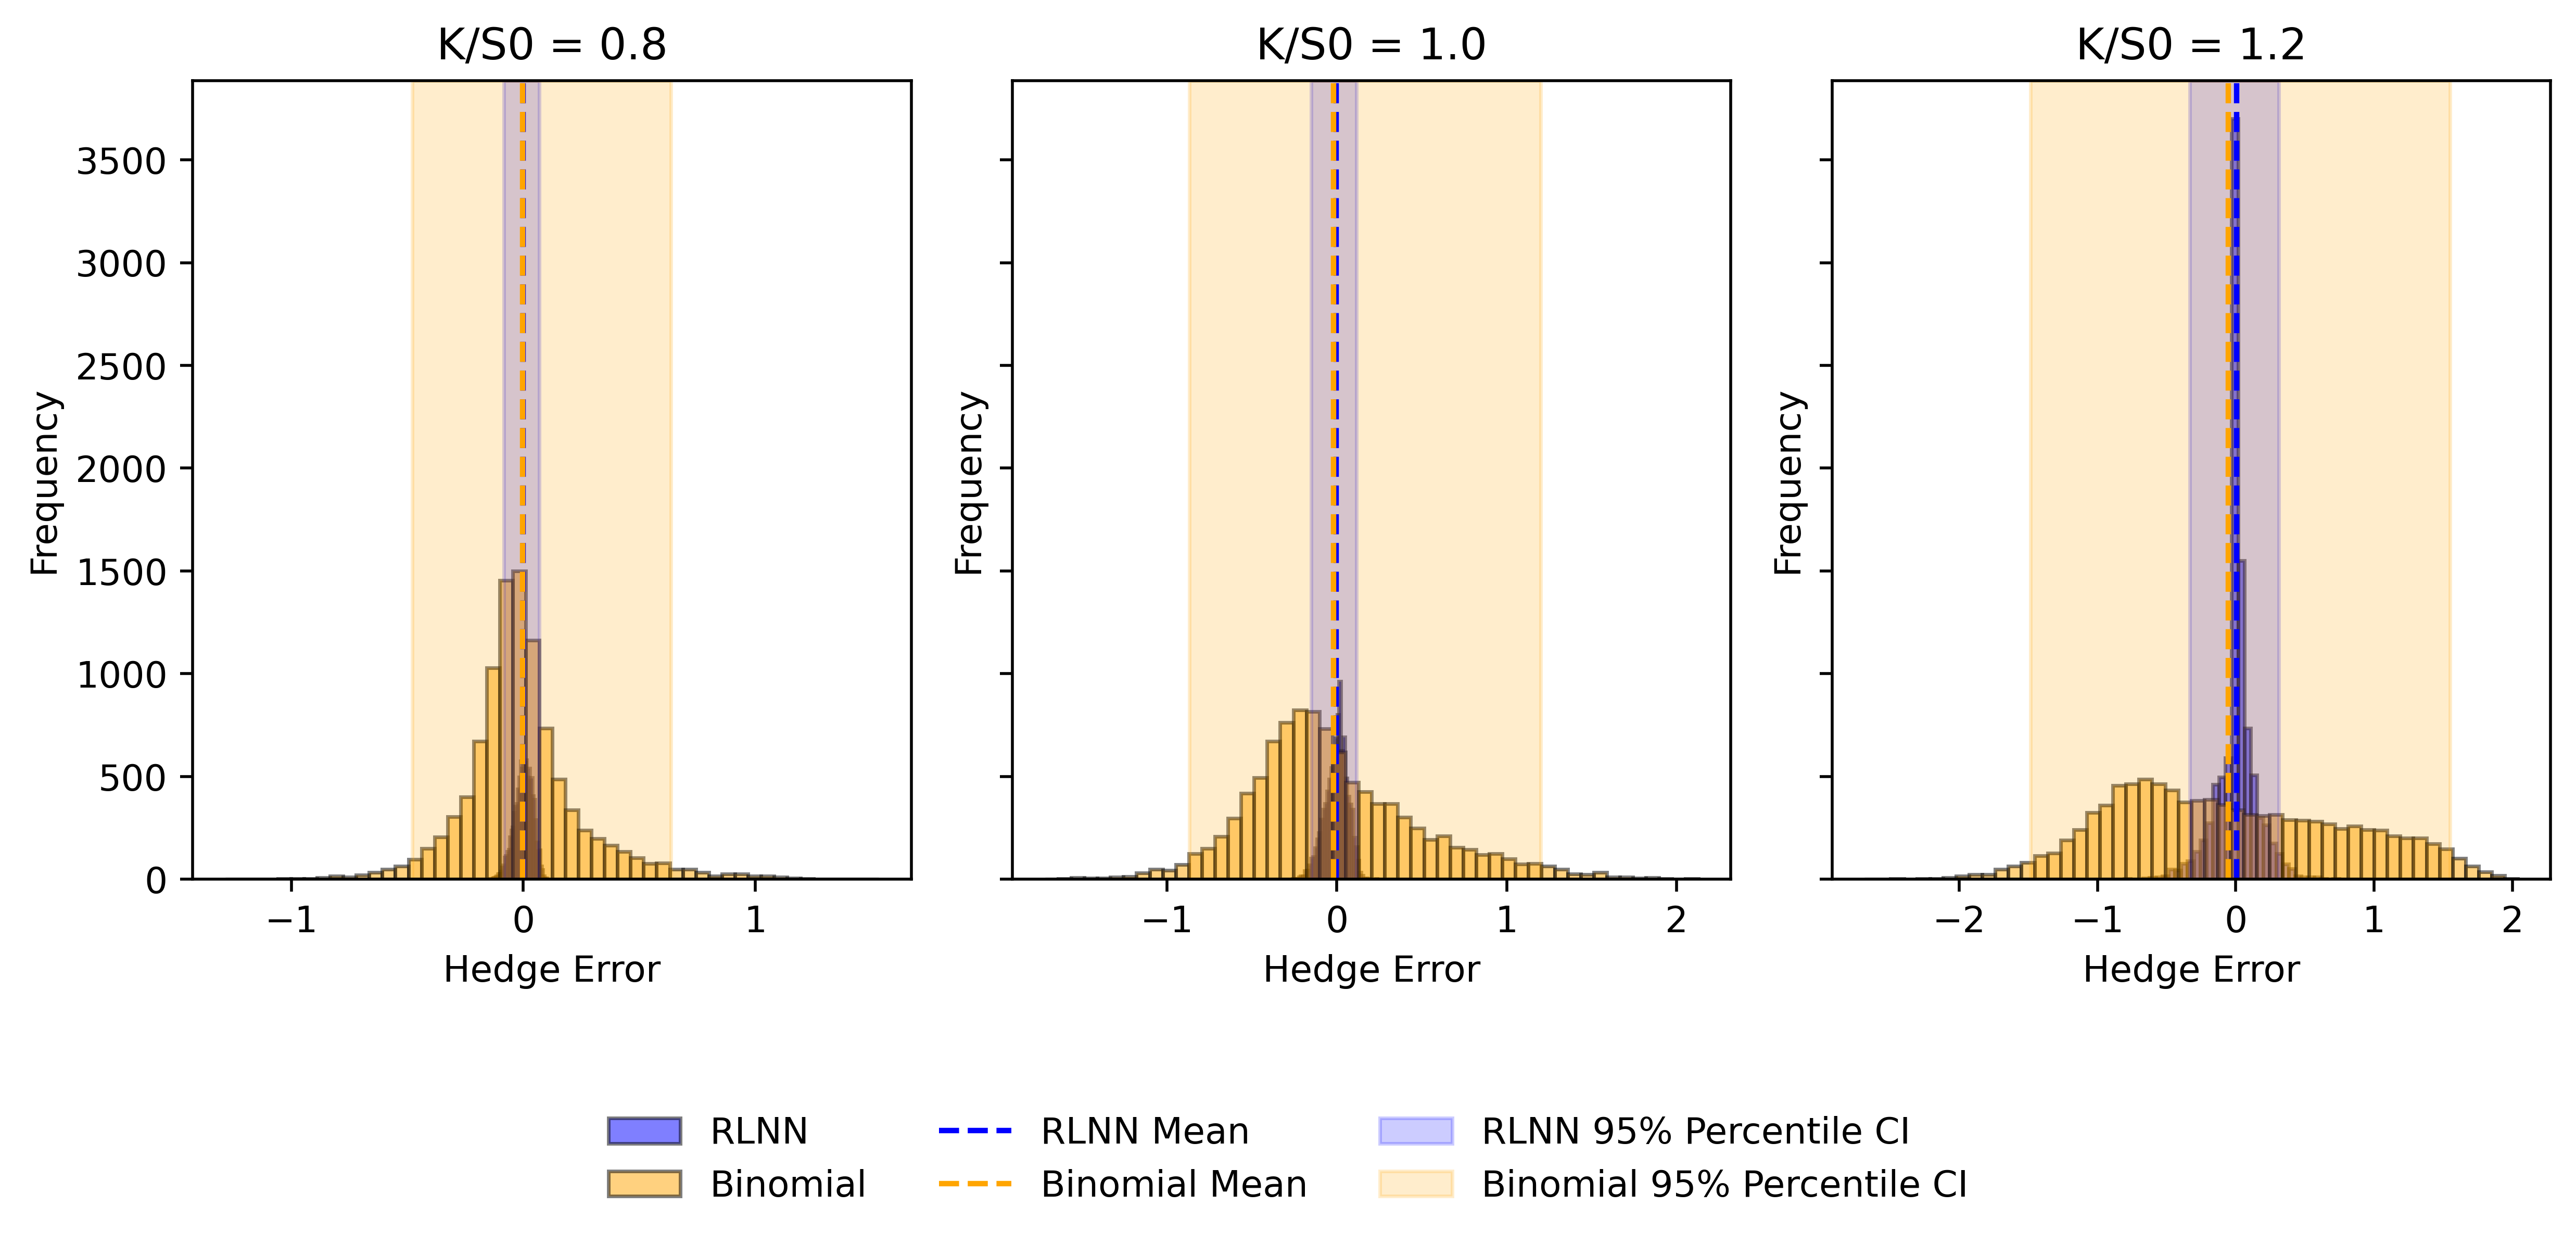

In [46]:
# Plot histograms comparing RLNN vs. Binomial for each strike ratio with 95% Percentile CI
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True, dpi=500)  # Set high DPI here

# Plot function for individual axes
def plot_with_percentile_ci(ax, data_rlnn, data_bin, title, xlabel):
    mean_rlnn = np.mean(data_rlnn)
    ci_rlnn = (np.percentile(data_rlnn, 2.5), np.percentile(data_rlnn, 97.5))
    mean_bin = np.mean(data_bin)
    ci_bin = (np.percentile(data_bin, 2.5), np.percentile(data_bin, 97.5))

    # Plot data
    ax.hist(data_rlnn, bins=50, alpha=0.5, color='blue', edgecolor='black', label='RLNN')
    ax.hist(data_bin, bins=50, alpha=0.5, color='orange', edgecolor='black', label='Binomial')
    ax.axvline(x=mean_rlnn, color='blue', linestyle='--', label='RLNN Mean')
    ax.axvline(x=mean_bin, color='orange', linestyle='--', label='Binomial Mean')
    ax.axvspan(ci_rlnn[0], ci_rlnn[1], color='blue', alpha=0.2, label='RLNN 95% Percentile CI')
    ax.axvspan(ci_bin[0], ci_bin[1], color='orange', alpha=0.2, label='Binomial 95% Percentile CI')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Frequency")

# Generate individual subplots
plot_with_percentile_ci(axes[0], hedge_error_rlnn_08, hedge_error_bin_08, "K/S0 = 0.8", "Hedge Error")
plot_with_percentile_ci(axes[1], hedge_error_rlnn_10, hedge_error_bin_10, "K/S0 = 1.0", "Hedge Error")
plot_with_percentile_ci(axes[2], hedge_error_rlnn_12, hedge_error_bin_12, "K/S0 = 1.2", "Hedge Error")

# Add a shared legend below the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.2), 
    ncol=3,
    frameon=False
)
fig.subplots_adjust(bottom=0.3) 

# plt.suptitle(f"Comparison of RLNN vs. Binomial Delta-Hedging Errors\n(vol={vol})")
plt.tight_layout()

# Display the figure
plt.show()


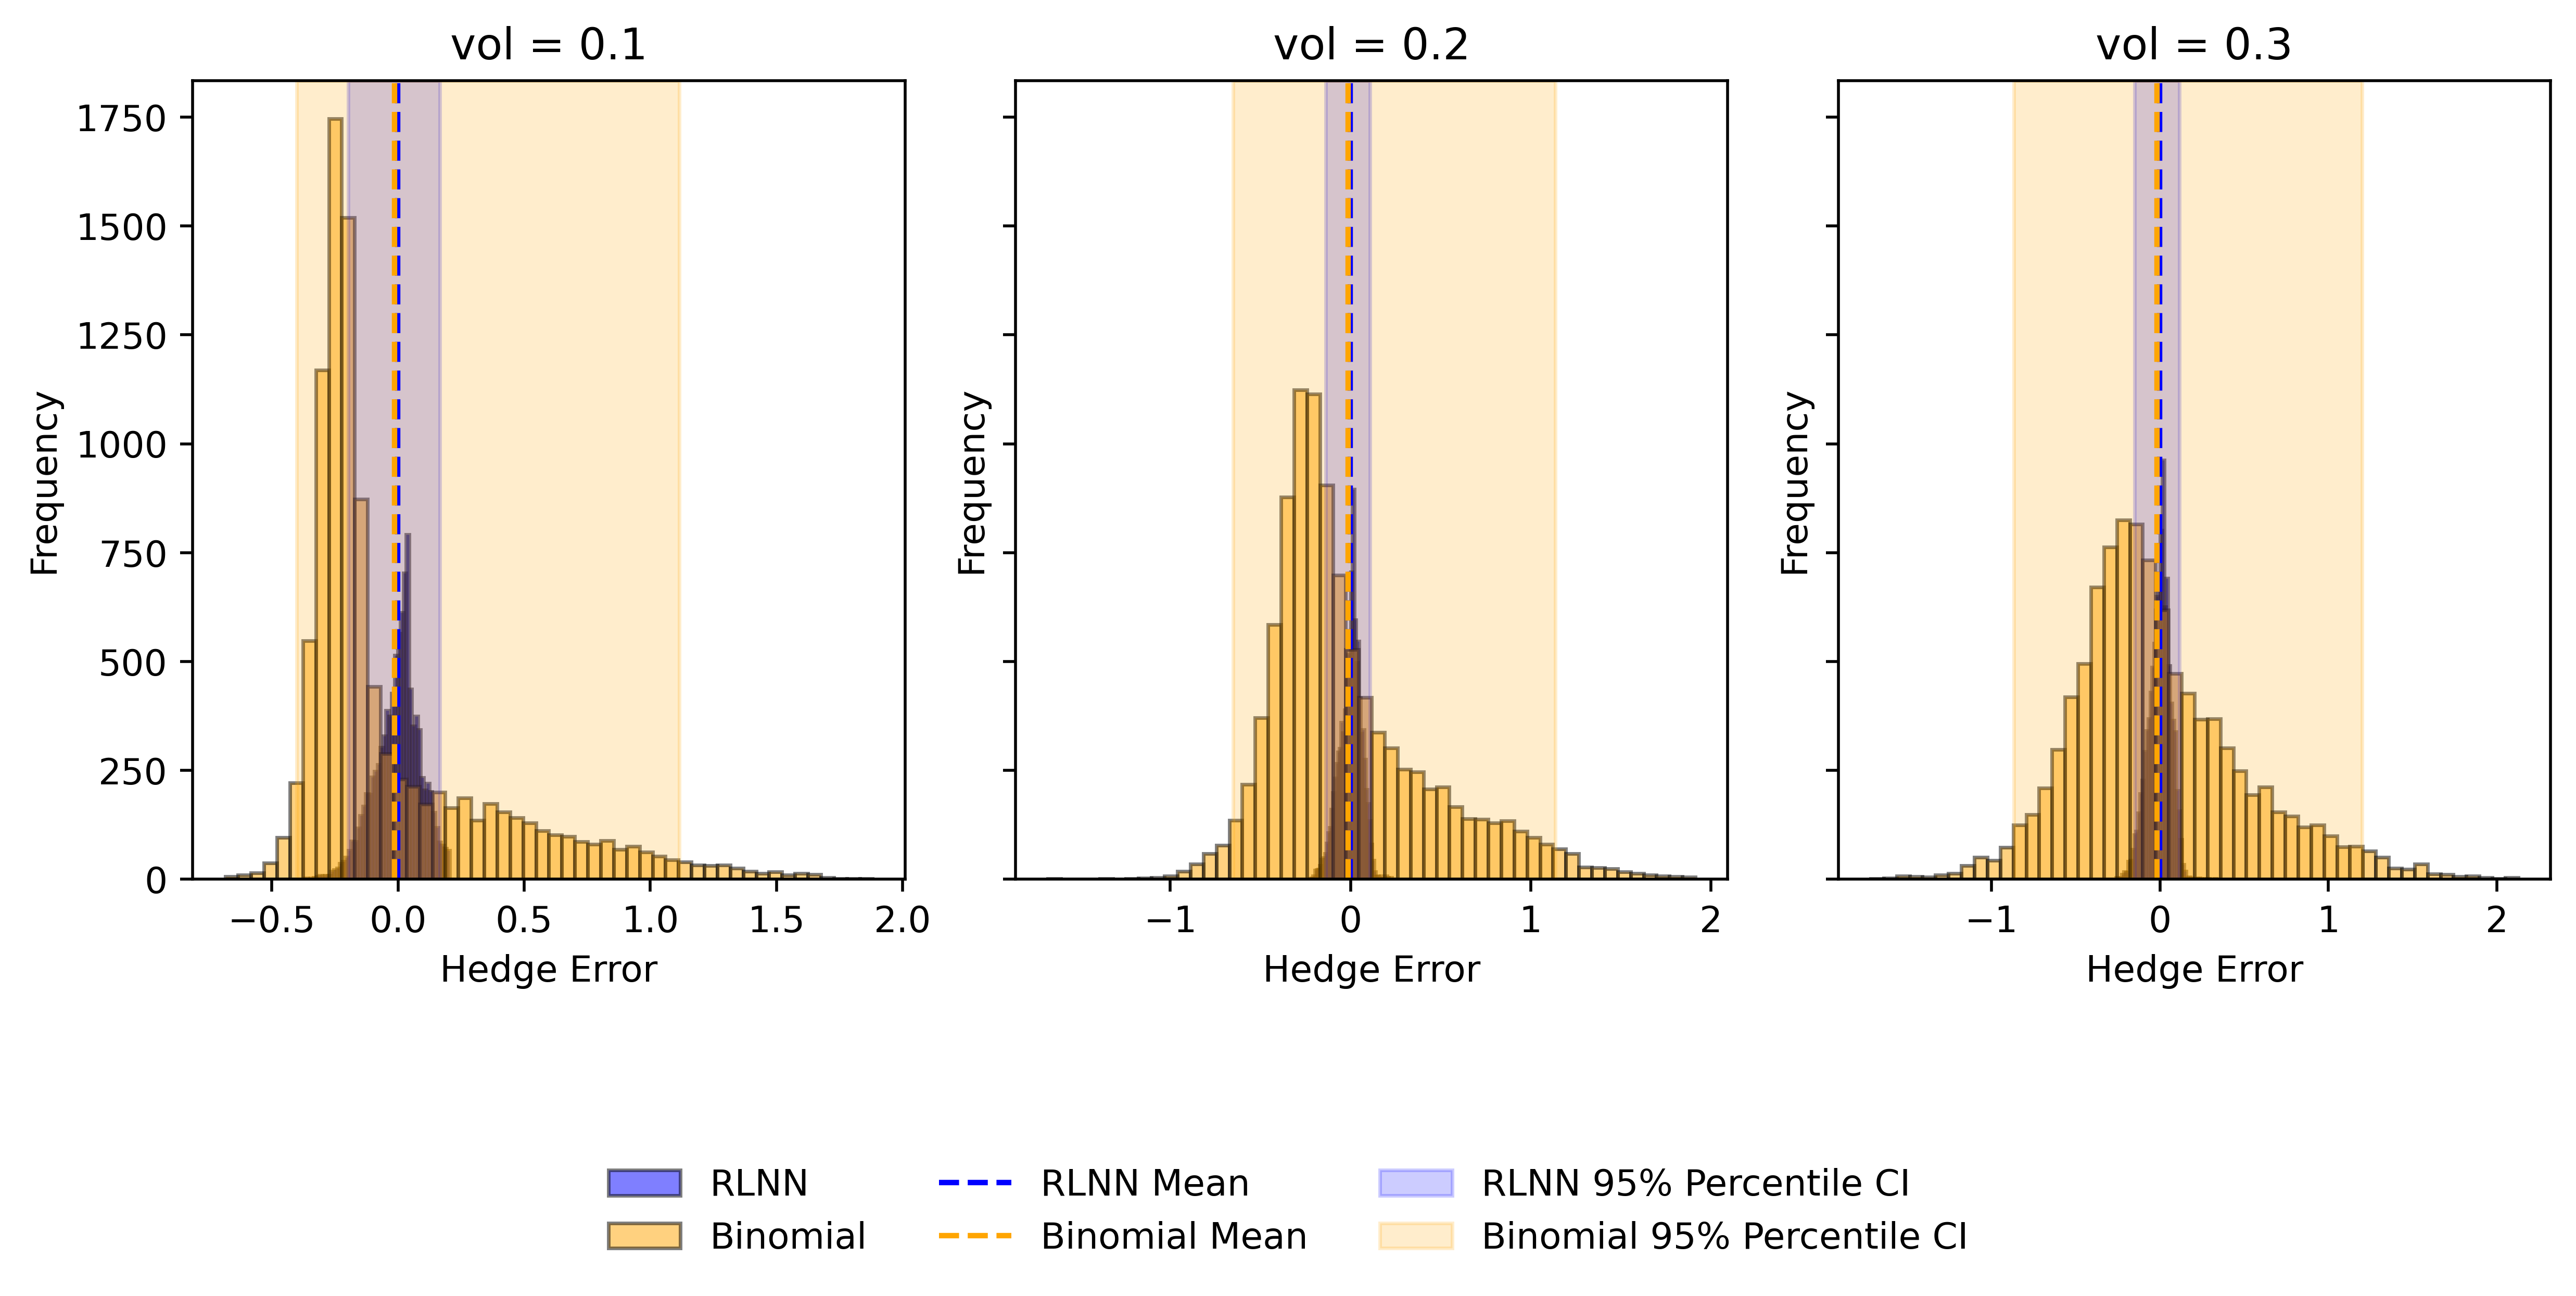

In [44]:
# compare vol = 0.1, 0.2, 0.3
vol_list = [0.1, 0.2, 0.3]

# Wmake a 1-row by 3-column figure
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True, dpi=500)

for i, vol in enumerate(vol_list):
    # Retrieve RLNN and Binomial data from the dictionary
    key_rlnn = f"hedge_error_rlnn_10_vol_{vol}_10000"
    key_bin  = f"hedge_error_bin_10_vol_{vol}_10000"
    
    data_rlnn = all_hedge_errors[key_rlnn]
    data_bin  = all_hedge_errors[key_bin]
    
    # Plot them side by side
    title = f"vol = {vol}"
    plot_with_percentile_ci(axes[i], data_rlnn, data_bin, title, "Hedge Error")

# Create a single legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25), 
    ncol=3,
    frameon=False
)

fig.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.show()
